In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) 
from sidm.tools import ffschema, sidm_processor, utilities, scaleout, cutflow
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
importlib.reload(cutflow)
# plotting
import matplotlib.pyplot as plt
import mplhep as hep

# Load style sheet
# plt.style.use(hep.style.CMS)  # or ATLAS/LHCb2

# h, bins = np.histogram(np.random.random(1000))
# fig, ax = plt.subplots()
# hep.histplot(h, bins)

utilities.set_plot_style()

In [2]:
#client = scaleout.make_dask_client("tls://localhost:8786")
#client

In [3]:
SIDM_samples = [
    #"2Mu2E_100GeV_1p2GeV_9p6mm", 
    "4Mu_100GeV_1p2GeV_9p6mm",
    
    #"2Mu2E_1000GeV_0p25GeV_0p02mm",
    "4Mu_1000GeV_0p25GeV_0p02mm",

    "4Mu_100GeV_5GeV_0p4mm"
]


samples = [
    "DYJetsToLL_M10to50", # Background
    "DYJetsToLL_M50",
    
    "QCD_Pt15to20", #Works
    #"QCD_Pt20to30", #issue, needs many files to fill all histograms
    #"QCD_Pt30to50", #Broken, throws KeyError: 'akjet_ak4PFJetsCHS_jetid'
    #"QCD_Pt50to80", #Works
    #"QCD_Pt80to120", #Works
    #"QCD_Pt120to170", # Really broken, Exception: Failed processing file: WorkItem(dataset='QCD_Pt120to170' ...)
    #"QCD_Pt170to300", #Works
    #"QCD_Pt300to470", #Works
    #"QCD_Pt470to600", #Works
    #"QCD_Pt600to800", #Works
    #"QCD_Pt800to1000", #Works
    #"QCD_Pt1000toInf", #Works
    
    "TTJets",
    "WW",
    "WZ",
    "ZZ",
]

for sample in SIDM_samples:
    samples.append(sample)

for sample in samples:
    print("Sample: " + sample)
    
#fileset = utilities.make_fileset(samples, "ffntuple_v2") #max_files argument was removed, so it defaults to use all the files in each sample
fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=4) #CHANGED: background appears to use v2 ntuples instead of v4

Sample: DYJetsToLL_M10to50
Sample: DYJetsToLL_M50
Sample: QCD_Pt15to20
Sample: TTJets
Sample: WW
Sample: WZ
Sample: ZZ
Sample: 4Mu_100GeV_1p2GeV_9p6mm
Sample: 4Mu_1000GeV_0p25GeV_0p02mm
Sample: 4Mu_100GeV_5GeV_0p4mm


In [4]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.DaskExecutor(client=client),
    #executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = [
            "2mu2e","4mu",
            "baseNoLj"
           ] # NOTE: the channel used determines the cuts applied. baseNoLj removes the checks for multiple jets.
p = sidm_processor.SidmProcessor(
    channels, ["test"]) # not sure if base_plus_gen applies to the background

# test if processor is serializable
import coffea.util as coffea_util
coffea_util.save(p, "processor.coffea")
print(coffea_util.load("processor.coffea"))


output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]

# Overall, this takes the samples listed in "samples" (section [2]), then processes them in the sidm_processor function.
# Without actual background data, I'm not sure of the format I should use for the samples, or whether the "base_plus_gen" set applies here.
# Regardless, the histograms generated should be stored in the variable "out".


Output()

Output()

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

In [5]:
out["4Mu_100GeV_1p2GeV_9p6mm"]["cutflow"]["baseNoLj"].print_table(fraction=True)

out["4Mu_1000GeV_0p25GeV_0p02mm"]["cutflow"]["baseNoLj"].print_table(fraction=True)

out["4Mu_100GeV_5GeV_0p4mm"]["cutflow"]["baseNoLj"].print_table(fraction=True)

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto             99.9          99.9            99.9
cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto             99.8          99.8            99.8


In [24]:
# Post-processing, combines background samples into larger sets.
# This applies to cutflows and to histograms

#These flags show whether DY, QCD, and dibosons should be combined into one variable.
bosons = True
QCD = True
DY = True
ttbar = True
#If this is true, all background samples will be combined into one. This automatically disables the other groupings.
TotalBackground = True

if TotalBackground == True:
    DY = False
    QCD = False
    bosons = False
    ttbar = False
    
sample_list = []
if DY == True:
    sample_list.append("DY_Jets")
if QCD == True:
    sample_list.append("QCD_Jets")
if bosons == True:
    sample_list.append("DiBoson_Jets")
if ttbar == True:
    sample_list.append("TT")
    
for sample in samples:
    if (sample[0] != 'D' and DY == True) and (sample[0] != 'Q' and QCD == True) and (sample[0] != 'W' and bosons == True) and (sample[0] != 'Z' and bosons == True) and (sample != 'TT' and ttbar == True):
        sample_list.append(sample)
        
QCD_samples = ["QCD_Pt15to20","QCD_Pt20to30","QCD_Pt30to50","QCD_Pt50to80","QCD_Pt80to120","QCD_Pt120to170",
               "QCD_Pt170to300","QCD_Pt300to470","QCD_Pt470to600","QCD_Pt600to800","QCD_Pt800to1000","QCD_Pt1000toInf"]

# post-processing, adds together all the histograms in the Drell-Yan set into DY_Hists

if DY == True:
    DY_Hists = output['out']["DYJetsToLL_M10to50"]["hists"]
    DY_Cutflow = output['out']["DYJetsToLL_M10to50"]["cutflow"]
    for channel in channels:
        DY_Cutflow[channel] = DY_Cutflow[channel] + output['out']["DYJetsToLL_M50"]["cutflow"][channel]
# Also adds together all QCD samples used
if QCD == True:
    QCD_Hists = output['out']["QCD_Pt15to20"]["hists"]
    QCD_Cutflow = output['out']["QCD_Pt15to20"]["cutflow"]
    for sample in samples:
        if (sample[0] == 'Q') and (sample != "QCD_Pt15to20"):
            for channel in channels:
                QCD_Cutflow[channel] = QCD_Cutflow[channel] + output['out'][sample]["cutflow"][channel]
# Now adds diboson samples together (not sure if TT_ is a diboson, might be quarks)
if bosons == True:
    DiBoson_Hists = output['out']["WW"]["hists"]     
    DiBoson_Cutflow = output['out']["WW"]["cutflow"]
    for channel in channels:
        DiBoson_Cutflow[channel] = DiBoson_Cutflow[channel] + output['out']["ZZ"]["cutflow"][channel]
        DiBoson_Cutflow[channel] = DiBoson_Cutflow[channel] + output['out']["WZ"]["cutflow"][channel]
    
if ttbar == True:
    TT_Hists = output['out']['TTJets']["hists"]
    TT_Cutflow = output['out']['TTJets']["cutflow"]
    
if TotalBackground == True:
    bg_Hists = output['out']["DYJetsToLL_M10to50"]["hists"]
    bg_Cutflow = output['out']["DYJetsToLL_M10to50"]["cutflow"]
    for sample in samples:
        if (sample[0] == 'D') or (sample[0] == 'Q') or (sample[0] == 'W') or (sample[0] == 'Z') and (sample != "DYJetsToLL_M10to50"):
            for channel in channels:
                bg_Cutflow[channel] = bg_Cutflow[channel] + output['out'][sample]["cutflow"][channel]
                
                
hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
collection = utilities.flatten(hist_menu["test"]) #To change the histograms used, swap "base" for the other collections
#collection.remove("lj_pfiso") #lj_pfiso is bugged, this line removes it

for hist_name in collection:
    if DY == True:
        #print("Adding " + hist_name + " to DY_Hists")
        DY_Hists[hist_name] = DY_Hists[hist_name] + output['out']["DYJetsToLL_M50"]["hists"][hist_name]
    if QCD == True:
        for sample in samples:
            if (sample[0] == 'Q') and (sample != "QCD_Pt15to20"):
                QCD_Hists[hist_name] = QCD_Hists[hist_name] + output['out'][sample]["hists"][hist_name]
    if bosons == True:
        DiBoson_Hists[hist_name] = DiBoson_Hists[hist_name] + output['out']["WZ"]["hists"][hist_name]
        DiBoson_Hists[hist_name] = DiBoson_Hists[hist_name] + output['out']["ZZ"]["hists"][hist_name]
    if TotalBackground == True:
        for sample in samples:
            if (sample[0] == 'D') or (sample[0] == 'Q') or (sample[0] == 'W') or (sample[0] == 'Z') and (sample != "DYJetsToLL_M10to50"):
                bg_Hists[hist_name] = bg_Hists[hist_name] + output['out'][sample]["hists"][hist_name]
                
            #print("Adding  " + sample + ' ' + hist_name + " histogram to QCD_Pt15to20")
# IMPORTANT: This sets DY_10to50 as the base for the DY_Hists. When DY_Hists is changed, so is DY_10to50. This
#            shouldn't matter, since the only one used will be DY_Hists in most cases, but this needs to be fixed.
#            The same issue is present with QCD_15to20 and QCD_Hists.

In [7]:
#This defines a function to break down the samples and make individual subplots for each one.
#First, it makes a list of all samples, replacing the individual background ones with any aggregates
#(DY, QCD, bosons). This does not include the total background one, since that can be plotted with a single function
#rather than this process. Next, it cycles through the list and plots all the samples.
#Note to fix: if one of the aggregates is disabled, the ordering of the plots breaks.
#Also, the argument nrow is now determined from number of samples and number of columns, so the input parameter is unnecessary.
# I should also set the specific range as a parameter. For now, it uses [ :1200j], and that seems to change as needed, but it could be an issue in the future.
sample_list = []
if DY == True:
    sample_list.append("DY_Jets")
if QCD == True:
    sample_list.append("QCD_Jets")
if bosons == True:
    sample_list.append("DiBoson_Jets")
    
for sample in samples:
    if (sample[0] != 'D' and DY == True) and (sample[0] != 'Q' and QCD == True) and (sample[0] != 'W' and bosons == True) and (sample[0] != 'Z' and bosons == True):
        sample_list.append(sample)
        
def plotSamples(hists, channel, errorBars, densityPlot, nrow=2, ncol=4, samples=sample_list, fullBg=TotalBackground):
    #Note that nrow gets overwritten. Might want to remove that.
    if fullBg == False:
        nplots = len(samples)
        nrow = (nplots-1)//ncol + 1
        if (nplots <= 5):
            ncol = nplots
            nrow = 1
        plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
        counter = 1
        print("Now plotting " + hists[0], end='')
        while counter < len(hists):
            print(" and " + hists[counter], end='')
            counter += 1
        print('.')
    
        for i in range(nplots):
            plt.subplot(nrow, ncol, i+1)
            plt.rcParams['font.size'] = 16
            if i==0 and DY == True:
                for hist in hists:
                    utilities.plot(DY_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])
            elif i==1 and QCD == True:
                for hist in hists:
                    utilities.plot(QCD_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])
            elif i==2 and bosons == True:
                for hist in hists:
                    utilities.plot(DiBoson_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])
            elif i <= nplots:
                for hist in hists:
                    utilities.plot(out[samples[i]]["hists"][hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])

    else: #case that background is combined together
        nplots = len(SIDM_samples) + 1
        if nplots <= 5:
            ncol = nplots
            nrow = 1
        else:
            nrow = (nplots-1)//ncol + 1
        plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
        counter = 1
        print("Now plotting " + hists[0], end='')
        while counter < len(hists):
            print(" and " + hists[counter], end='')
            counter += 1
        print('.')
        for i in range(nrow):
            for k in range(1, ncol+1):
                plt.subplot(nrow, ncol, k+i*ncol)
                plt.rcParams['font.size'] = 16
                if i==0 and k==1:
                    for hist in hists:
                        utilities.plot(bg_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                    if len(hists) > 1:
                        plt.legend(hists)
                    plt.title(samples[k+i*ncol-1])
                elif (k+i*ncol <= nplots):
                    for hist in hists:
                        utilities.plot(out[samples[k+i*ncol-1]]["hists"][hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                    if len(hists) > 1:
                        plt.legend(hists)
                    plt.title(samples[k+i*ncol-1])

In [8]:
#DY_Output = output['out']["DYJetsToLL_M10to50"]["hists"]["muon_pt"] + output['out']["DYJetsToLL_M50"]["hists"]["muon_pt"]
# Trying to combine all DY processes into one element
# This would use all DY processes at once
# Combining the files manually in the background (combining the categories of <50 and >50) wouldn't work, since only a few files are used overall.
# Should work going forward with DY_Output['hists']["muon_pt"]["baseNoLj", :], etc.
# from coffea.processor import accumulate
#double_out = accumulate([output["out"], output["out"]])
#DY = accumulate(output['out']["DYJetsToLL_M10to50"], output['out']["DYJetsToLL_M10to50"])
#DY = output['out']["DYJetsToLL_M10to50"]["hists"] + output['out']["DYJetsToLL_M50"]["hists"]
#print(output['out']["DYJetsToLL_M10to50"])
#print(output['out']["DYJetsToLL_M10to50"])

Text(0.5, 1.0, 'Combined BG')

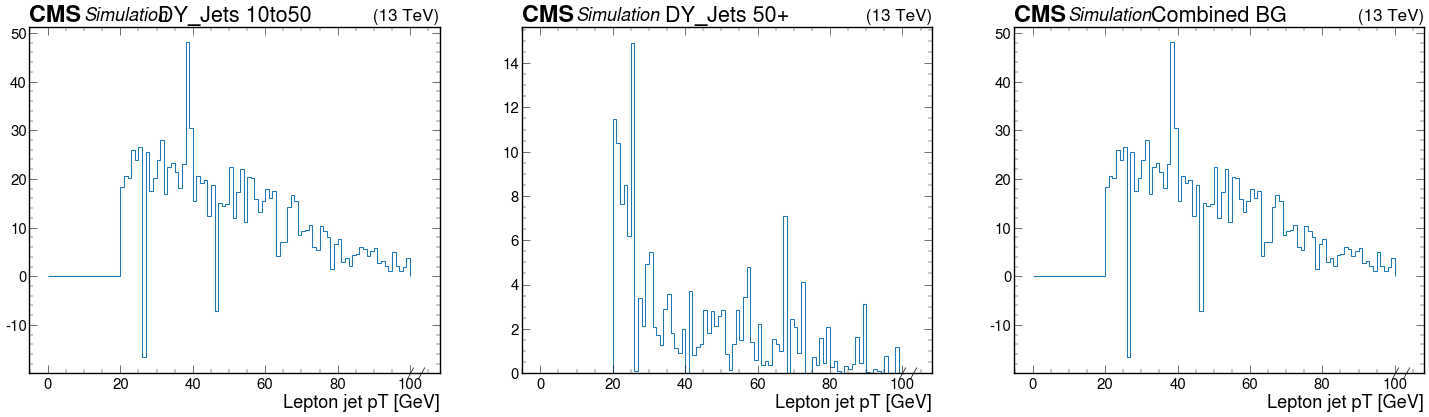

In [9]:
plt.subplots(1,3, figsize=(36, 9))
plt.subplot(1, 3, 1)
utilities.plot(out["DYJetsToLL_M10to50"]["hists"]["lj_pt"]["baseNoLj", :], density=False, yerr=False)
plt.title("DY_Jets 10to50")
plt.subplot(1, 3, 2)
utilities.plot(out["DYJetsToLL_M50"]["hists"]["lj_pt"]["baseNoLj", :], density=False, yerr=False)
plt.title("DY_Jets 50+")
plt.subplot(1, 3, 3)
#DY_plot = utilities.plot(out["DYJetsToLL_M10to50"]["hists"]["muon_pt"]["baseNoLj", :], density=True) + utilities.plot(out["DYJetsToLL_M50"]["hists"]["muon_pt"]["baseNoLj", :], density=True)
utilities.plot(bg_Hists["lj_pt"]['baseNoLj', :], density = False, yerr=False)
plt.title("Combined BG")
# Shows the issue with combining plots -- all combined plots are overwritten with the sum

In [10]:
bg_Cutflow["2mu2e"].print_table(fraction=True)

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto            100.0         100.0           100.0
>=2 LJs                 52.4          52.4            52.4
2mu2e                    3.8           7.3             3.8


In [12]:
if QCD:
    QCD_Cutflow["2mu2e"].print_table(fraction=True)
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)


In [13]:
if bosons:
    DiBoson_Cutflow["2mu2e"].print_table(fraction=True)

In [14]:
output['out']["2Mu2E_100GeV_1p2GeV_9p6mm"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["2Mu2E_100GeV_1p2GeV_9p6mm"]["cutflow"]["2mu2e"].print_table(fraction=True)
print()
output['out']["2Mu2E_100GeV_1p2GeV_9p6mm"]["cutflow"]["baseNoLj"].print_table()
print()

KeyError: '2Mu2E_100GeV_1p2GeV_9p6mm'

In [15]:
output['out']["4Mu_100GeV_1p2GeV_9p6mm"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["4Mu_100GeV_1p2GeV_9p6mm"]["cutflow"]["2mu2e"].print_table(fraction=True)
print()

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto             99.9          99.9            99.9
>=2 LJs                 35.4          35.4            35.4
4mu                     35.4          99.8            35.3

cut name        individual %    marginal %    cumulative %
------------  --------------  ------------  --------------
No selection           100.0         100.0           100.0
PV filter              100.0         100.0           100.0
Cosmic veto             99.9          99.9            99.9
>=2 LJs                 35.4          35.4            35.4
2mu2e                    0.1           0.2             0.1



NameError: name 'DY_Hists' is not defined

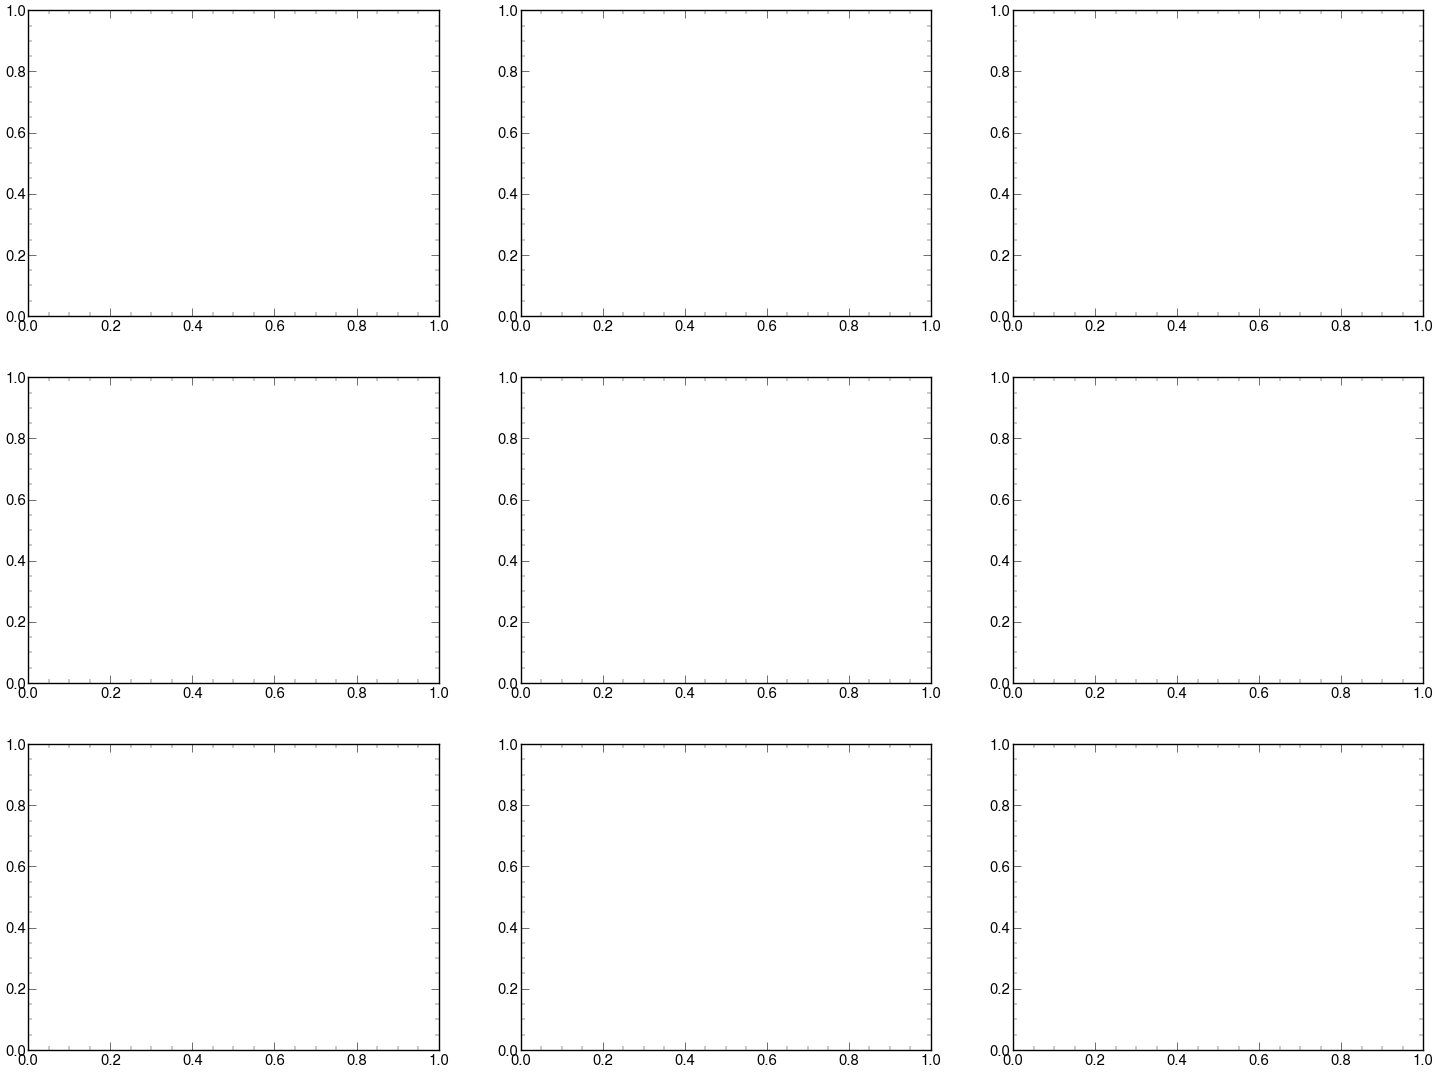

In [16]:
nrow = 3
ncol = 3
nplots = nrow*ncol
sample_list = ["DY_Jets", "QCD_Jets"]
for sample in samples:
    if (sample[0] != 'D') and (sample[0] != 'Q'):
        sample_list.append(sample)

plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
figure_plotted_hists = [["lj_n", True], ["muon_pt", True], ["lj_lj_absdphi", False]]
# each element is ["Hist_name", Density]

for i in range(len(figure_plotted_hists)):
    for j in range(1, ncol+1):
        plt.subplot(nrow, ncol, j+i*ncol)
        
        utilities.plot(DY_Hists[figure_plotted_hists[i][0]][channels[j-1], :], yerr=False, density=figure_plotted_hists[i][1])
        utilities.plot(QCD_Hists[figure_plotted_hists[i][0]][channels[j-1], :], yerr=False, density=figure_plotted_hists[i][1])

        for sample in sample_list:
            if sample[0] != 'D' and sample[0] != 'Q':
                utilities.plot(out[sample]["hists"][figure_plotted_hists[i][0]][channels[j-1], :], yerr=False, density=figure_plotted_hists[i][1])

        plt.ylabel("Arbitrary units")
        plt.legend(sample_list, loc=1, prop={'size': 16})
        plt.title(channels[j-1] + ' ' + figure_plotted_hists[i][0])

Now plotting muon_pt.


KeyError: 'muon_pt'

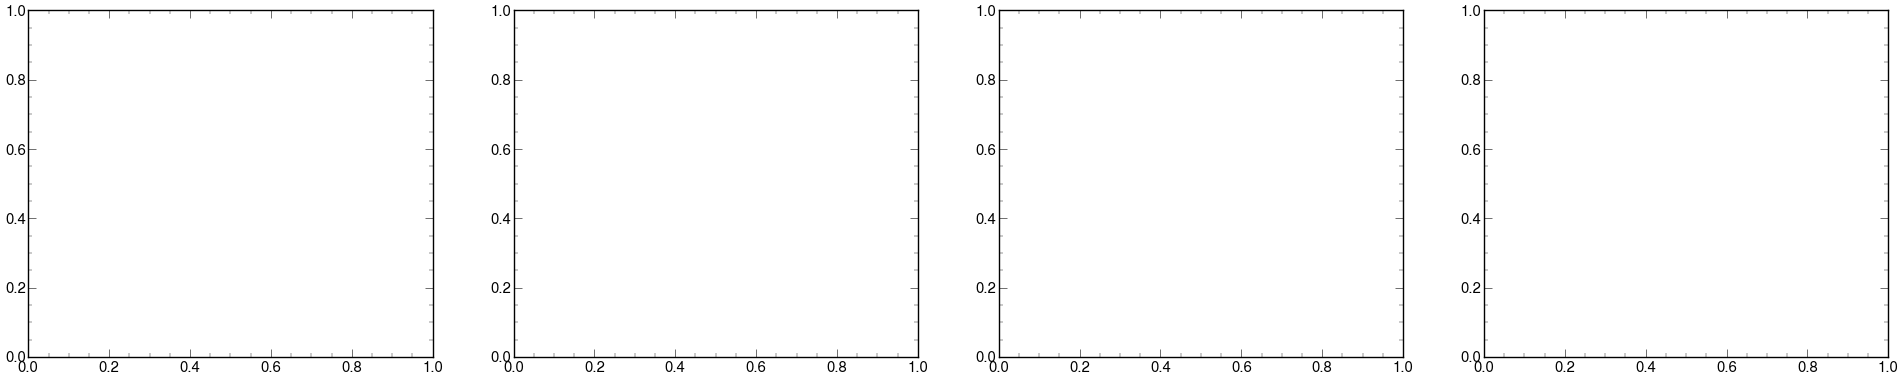

In [17]:
plotSamples(["muon_pt"], "baseNoLj", False, True)

From the muon_pt plots, it's clear that many of the background types do not have enough data to support useful histograms. Even in the baseNoLj channel, WW and ZZ especially have few samples. One of the ZZ bins is negative and the overall shape follows a trend, but is small enough that some bins are nearly empty. Furthermore, it is clear from a first glance what QCD bin was excluded (30-50). This needs to be fixed to smooth out the plot.

In [18]:
utilities.plot(DiBoson_Hists["muon_pt"]["baseNoLj", :200j], yerr=False, density=True)

NameError: name 'DiBoson_Hists' is not defined

['DY_Jets', 'QCD_Jets', 'TTJets', 'WW', 'WZ', 'ZZ', '4Mu_100GeV_1p2GeV_9p6mm', '4Mu_1000GeV_0p25GeV_0p02mm', '4Mu_100GeV_5GeV_0p4mm']
Now plotting lj0_pt.


KeyError: 'lj0_pt'

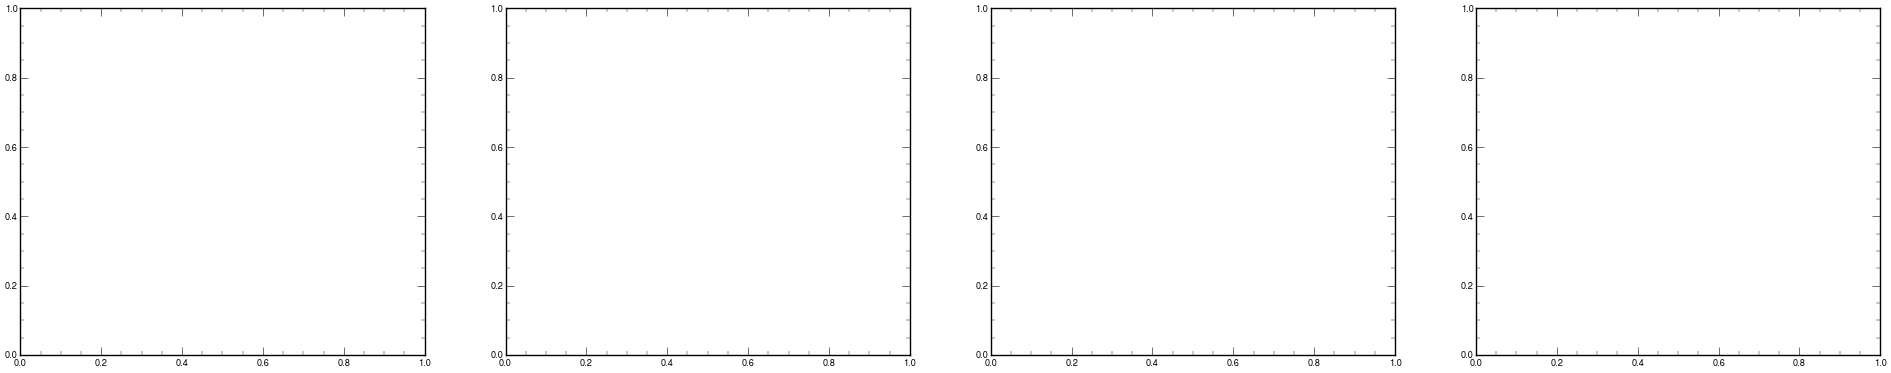

In [19]:
print(sample_list)

plotSamples(["lj0_pt"], "baseNoLj", False, True)

['DY_Jets', 'QCD_Jets', 'TTJets', 'WW', 'WZ', 'ZZ', '4Mu_100GeV_1p2GeV_9p6mm', '4Mu_1000GeV_0p25GeV_0p02mm', '4Mu_100GeV_5GeV_0p4mm']
Now plotting lj_lj_invmass and lj_pt.


KeyError: 'lj_lj_invmass'

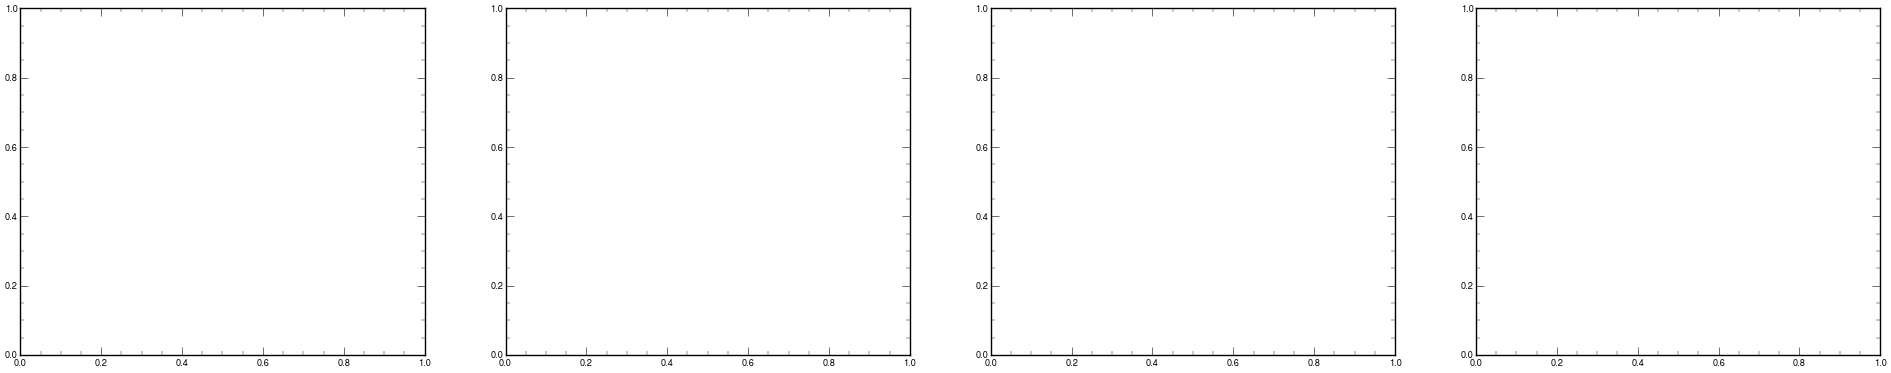

In [20]:
print(sample_list)

plotSamples(["lj_lj_invmass", "lj_pt"], "baseNoLj", False, True)

In [ ]:
plotSamples(["lj_lj_absdphi"], "baseNoLj", False, True)

In [ ]:
utilities.plot(QCD_Hists["muon_pt"]["2mu2e", :], yerr=False, density=False)

In [ ]:
nrow = 2
ncol = 3
nplots = nrow*ncol

plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))

for i in range(1, ncol+1):
    plt.subplot(nrow, ncol, i)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["lj0_dRSpread"][channels[i-1], :.02j], yerr=False, density=False, flow='none')
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylabel("Arbitrary units")
    plt.legend(samples, loc=1, prop={'size': 16})
    plt.title("Leading LJ " + channels[i-1])
    
for i in range(1, ncol+1):
    plt.subplot(nrow, ncol, i+ncol)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["lj1_dRSpread"][channels[i-1], :.02j], yerr=False, density=False, flow='none')
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylabel("Arbitrary units")
    plt.legend(samples, loc=1, prop={'size': 16})
    plt.title("Subleading LJ " + channels[i-1])

In [ ]:
if 0:
    nplots = 2
    plt.subplots(1, nplots, figsize=(nplots*12, 10))
    plt.subplot(1, nplots, 1)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["muon_n"][channels[2], :], density=True)
        # plt.legend(masses, title="DM bound state mass", alignment="left")
        plt.ylabel("Arbitrary units")
    plt.subplot(1, nplots, 2)
    for sample in samples:
        utilities.plot(out[sample]["hists"]["electron_n"][channels[2], :], density=True)
        #plt.legend(masses, title="DM bound state mass", alignment="left")
        plt.ylabel("Arbitrary units")

In [33]:
samples_used = []
cutflows_used = []

if TotalBackground == True:
    samples_used.append("Background")
    init_cutflow = bg_Cutflow["4mu"]
else:
    init_sample = samples[0]
    init_cutflow = out[init_sample]["cutflow"]["4mu"]
    
for sample in samples:
    if sample[0] == '2' or sample[0] == '4':
        samples_used.append(sample)
        cutflows_used.append(out[sample]["cutflow"]["4mu"])
if samples_used[0][0] == 2 or samples_used == 4:
    cutflows_used.remove(out[init_sample]["cutflow"]["4mu"])

init_cutflow.print_multi_table(cutflows_used, samples_used, True)

cut name        % cuts in                  % cuts in                     % cuts in                % cuts in
                Background    4Mu_100GeV_1p2GeV_9p6mm    4Mu_1000GeV_0p25GeV_0p02mm    4Mu_100GeV_5GeV_0p4mm
------------  ------------  -------------------------  ----------------------------  -----------------------
No selection         100.0                      100.0                         100.0                    100.0
PV filter            100.0                      100.0                         100.0                    100.0
Cosmic veto          100.0                       99.9                         100.0                     99.8
>=2 LJs               53.1                       35.4                          41.4                     61.1
4mu                    0.1                       35.3                          41.0                     61.1




In [22]:
sample_used = "4Mu_100GeV_1p2GeV_9p6mm"
cut_samples = [
    "4Mu_1000GeV_0p25GeV_0p02mm",
    "4Mu_100GeV_5GeV_0p4mm"
]
headers = [sample_used]
cut_used = out[sample_used]["cutflow"]["baseNoLj"]
cutflow_list = []
for sample in cut_samples:
    cutflow_list.append(out[sample]["cutflow"]["baseNoLj"])
    headers.append(sample)
    
    
cut_used.print_multi_table(cutflow_list, headers, False, False, "Cuts in SIDM samples")

cut_used.print_multi_table(cutflow_list, headers, True, False, "Fractional SIDM cuts")

Cuts in SIDM samples
--------------------------------------------------------------------------------------------------------------------------- 
cut name                 Total cuts in                 Total cuts in            Total cuts in
                4Mu_100GeV_1p2GeV_9p6mm    4Mu_1000GeV_0p25GeV_0p02mm    4Mu_100GeV_5GeV_0p4mm
------------  -------------------------  ----------------------------  -----------------------
No selection                    20195.1                        9108.8                   9226.1
PV filter                       20195.1                        9108.8                   9226.1
Cosmic veto                     20178.0                        9106.2                   9212.2


Fractional SIDM cuts
--------------------------------------------------------------------------------------------------------------------------- 
cut name                     % cuts in                     % cuts in                % cuts in
                4Mu_100GeV_1p2GeV_9p6mm    